In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import zipfile
from tqdm.notebook import tqdm
from shutil import make_archive

In [8]:
#Change the datasetPath according to your Dataset Path
datasetPath = "./drive/MyDrive/Colab Notebooks/Capstone Project/Facial Expression Dataset Cleaned.zip"

with zipfile.ZipFile(datasetPath) as file :
    file.extractall()

In [9]:
for i in os.listdir("./Facial Expression Dataset Cleaned/train") :
    print(i, ":", len(os.listdir("./Facial Expression Dataset Cleaned/train/" + i)))

angry : 5004
disgust : 973
neutral : 16555
sad : 7269
surprise : 4849
fear : 4266
happy : 24079


In [10]:
def prepareImage(path) :
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (48, 48))
    return img

In [11]:
trainDir = "./Facial Expression Dataset Cleaned/train/"
expression = ["angry", "happy", "sad", "neutral"]

imgTrain = []
labelTrain = []

numOfData = 4000
for label, labelName in enumerate(expression) :
    for i in tqdm(os.listdir(trainDir + labelName)[:numOfData]) :
        imgTrain.append(prepareImage(os.path.join(trainDir, labelName, i)))
        tempLabel = np.zeros(len(expression))
        tempLabel[label] = 1
        labelTrain.append(tempLabel)

imgTrain = np.array(imgTrain)
labelTrain = np.array(labelTrain)

index = np.arange(len(expression) * numOfData)
np.random.seed(1)
np.random.shuffle(index)

imgTrain = imgTrain[index]
labelTrain = labelTrain[index]

In [12]:
baseModel = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(48, 48, 3))
avg = tf.keras.layers.GlobalAveragePooling2D()(baseModel.output)
dense1 = tf.keras.layers.Dense(100, activation="relu")(avg)
dense2 = tf.keras.layers.Dense(100, activation="relu")(dense1)
output = tf.keras.layers.Dense(len(expression), activation="softmax")(dense2)
model = tf.keras.models.Model(inputs=baseModel.input, outputs=output)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

for i in baseModel.layers :
    i.trainable = True

#model.summary()

In [ ]:
history = model.fit(imgTrain, labelTrain, epochs=20, validation_split=0.1)

Epoch 1/20
450/450 [==============================] - 14s 23ms/step - loss: 1.1696 - accuracy: 0.4928 - val_loss: 2.7999 - val_accuracy: 0.4594
Epoch 2/20
450/450 [==============================] - 10s 21ms/step - loss: 0.9354 - accuracy: 0.6146 - val_loss: 1.5249 - val_accuracy: 0.5825
Epoch 3/20
450/450 [==============================] - 10s 21ms/step - loss: 0.8188 - accuracy: 0.6754 - val_loss: 2.0624 - val_accuracy: 0.5512
Epoch 4/20
450/450 [==============================] - 10s 21ms/step - loss: 0.7850 - accuracy: 0.6903 - val_loss: 1.8744 - val_accuracy: 0.5800
Epoch 5/20
450/450 [==============================] - 10s 21ms/step - loss: 0.7654 - accuracy: 0.6943 - val_loss: 2.2080 - val_accuracy: 0.4013
Epoch 6/20
450/450 [==============================] - 10s 21ms/step - loss: 0.7924 - accuracy: 0.6808 - val_loss: 1.6425 - val_accuracy: 0.5625
Epoch 7/20
450/450 [==============================] - 10s 22ms/step - loss: 0.7170 - accuracy: 0.7182 - val_loss: 5.0202 - val_accuracy:

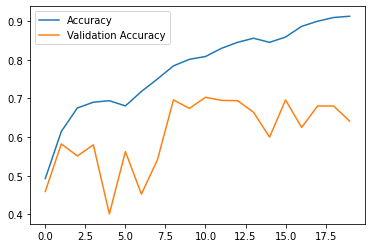

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [ ]:
testDir = "./Facial Expression Dataset Cleaned/test/"

imgTest = []
labelTest = []

numOfData = 500
for label, labelName in enumerate(expression) :
    for i in tqdm(os.listdir(testDir + labelName)[:numOfData]) :
        imgTest.append(prepareImage(os.path.join(testDir, labelName, i)))
        tempLabel = np.zeros(len(expression))
        tempLabel[label] = 1
        labelTest.append(tempLabel)

imgTest = np.array(imgTest)
labelTest = np.array(labelTest)

prediction = model.predict(imgTest)
cm = confusion_matrix(np.argmax(labelTest, axis=1), np.argmax(prediction, axis=1))

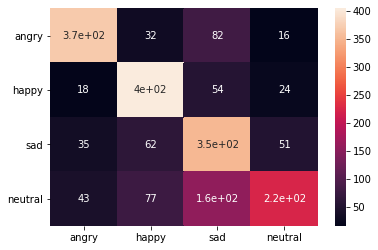

In [ ]:
sns.heatmap(cm, annot=True, xticklabels=expression, yticklabels=expression)
plt.yticks(rotation=0)
plt.show()

Label : happy    Prediction : happy


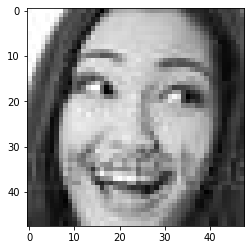

In [ ]:
#Range of index is 0 - 1999. Change index if you want to test other image
index = 509

print("Label :", expression[np.argmax(labelTest[index])], "   Prediction :", expression[np.argmax(prediction[index])])
plt.imshow(imgTest[index])
plt.show()

In [14]:
fileName = "savedModel"

model.save(fileName)
make_archive(fileName, "zip", fileName)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: savedModel/assets


'/content/savedModel.zip'

In [15]:
converter = tf.lite.TFLiteConverter.from_saved_model(fileName)
tflite_model = converter.convert()

with open(fileName + ".tflite", "wb") as f:
  f.write(tflite_model)